lets activate Autoreload in order to all changed code before any execution

In [1]:
%reload_ext autoreload
%autoreload 2

# Lets imoprt all the libraries we need

In [2]:
# ---------------------------------- Models ---------------------------------- #
from darts.models import TFTModel
import torch

# ---------------------------------- Tabular --------------------------------- #
import pandas as pd
import numpy as np

# ----------------------------------- Utils ---------------------------------- #
from darts import TimeSeries
import matplotlib.pyplot as plt

Importing plotly failed. Interactive plots will not work.


In [3]:
# check if working in colab
try:
    # In colab
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/projects/paris-traffic-forecast
    %pip install -q darts

except:
    # In local
    A = %pwd
    if A.split('/')[-1] == "notebooks":
        %cd ..
%pwd

/mnt/c/Users/Mustapha/Documents/competitions/BCG_Gamma/paris-traffic-forecast


'/mnt/c/Users/Mustapha/Documents/competitions/BCG_Gamma/paris-traffic-forecast'

## Needs

Prior to executing this notebook you should have your data in the data folder, please execute the bash script `data_src/get_data.sh` to download the data.

In [4]:
# !./data_src/get_data.sh

# Get data

In [5]:
data_paths = ["data/AV_Champs_Elysees.csv", "data/Convention.csv", "data/Sts_Peres.csv"]
time_col = "Date et heure de comptage"
input_cols = ["Date et heure de comptage"]
output_cols = ["Débit horaire", "Taux d'occupation"]

df = pd.read_csv(data_paths[0], sep=";").sort_values(time_col)
# print("all data :")
# display(df.head(2))
print("Important data :")
display(df[input_cols+output_cols].head())

Important data :


,Date et heure de comptage,Débit horaire,Taux d'occupation
4253,2020-11-01T04:00:00+01:00,34.0,0.40111
4258,2020-11-01T05:00:00+01:00,40.0,0.48389
3155,2020-11-01T06:00:00+01:00,66.0,0.75056
3535,2020-11-01T07:00:00+01:00,108.0,0.99611
4251,2020-11-01T08:00:00+01:00,126.0,1.09889


Data will be linearly interpolated, nan values will be replaced by the weighted average of the surrounding values != np.nan


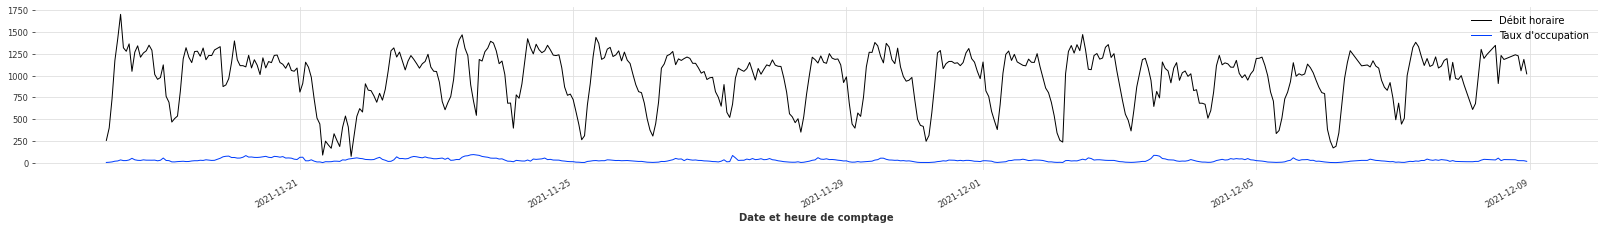

In [6]:
# ------------------------------ Other approach ------------------------------ #
# X = pd.DatetimeIndex(pd.to_datetime(df['Date et heure de comptage'], utc=True).dt.tz_localize(None))
# Y = df[output_cols]

# ---------------------------- Nouamane's approach --------------------------- #
new_df = df.copy()
new_df[time_col] = pd.to_datetime(df[time_col], utc=True).dt.tz_localize(None)
new_df[time_col] = pd.DatetimeIndex(new_df[time_col])
new_df = new_df.set_index(time_col)

ts = TimeSeries.from_dataframe(new_df, 
                          value_cols=output_cols,
                          fill_missing_dates=True,
                          freq='H')

# ------------------------------ Missing values ------------------------------ #
print("Data will be linearly interpolated, nan values will be replaced by the weighted average of the surrounding values != np.nan")
ts._xa.values = pd.DataFrame(ts.values()).interpolate().to_numpy().reshape((-1, len(output_cols), 1)) #Not the most intuitive way to do it, but it works with one line of code :D
# ---------------------------------- Ploting --------------------------------- #
# fig, _ = plt.subplots(figsize=(28, 4))
# ts[-900:].plot(lw=1, figure = fig)
plt.figure(figsize=(28, 3))
ts[-500:].plot(lw=1)

# Play ground

# Model testing

In [7]:
model = TFTModel(n_epochs=2000, batch_size=128, add_relative_index=True, optimizer_kwargs={"lr": 0.02})
predict_preiod = 24*5
# train, val = ts[:-predict_preiod], ts[-predict_preiod:]
delta = pd.Timedelta(str(predict_preiod)+' H')
split_time = ts.time_index[-1] - delta
train, val = ts.split_after(split_time)

In [8]:
# model.fit(train, past_covariates=train)
model.fit(train)

[2021-12-10 09:25:58,599] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3537 samples.
[2021-12-10 09:25:58,599] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3537 samples.
[2021-12-10 09:25:58,808] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-10 09:25:58,808] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
/home/mus5900/anaconda3/envs/series_forcasting/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


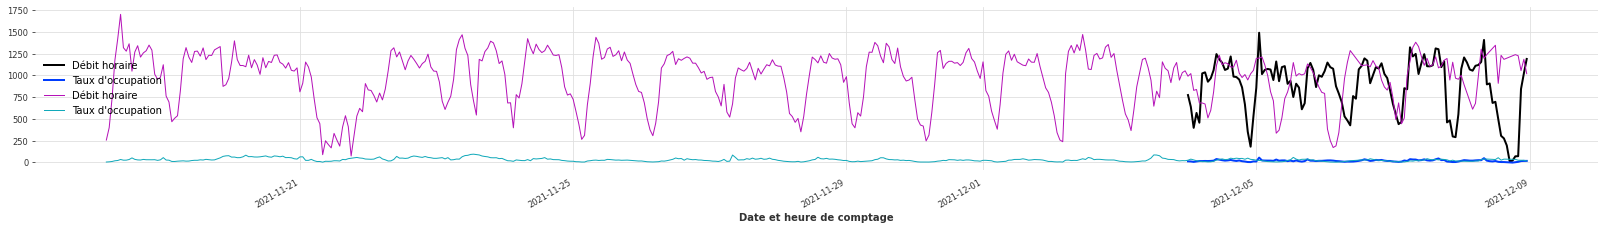

In [9]:
# tmp = TimeSeries.concatenate(train, val[:15])
# pred = model.predict(16, past_covariates=tmp)
pred = model.predict(predict_preiod)
plt.figure(figsize=(28, 3))
pred[-500:].plot(lw=2)
ts[-500:].plot(lw=1)

### Other

In [66]:
model_2 = TFTModel(n_epochs=150, batch_size=512, add_relative_index=True, optimizer_kwargs={"lr": 0.02}, hidden_size=4, input_chunk_length=128)
model_2.fit(train, verbose=True)

[2021-12-10 14:55:19,618] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 9421 samples.
[2021-12-10 14:55:19,618] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 9421 samples.
[2021-12-10 14:55:19,631] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-10 14:55:19,631] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/150 [00:00<?, ?it/s]

/home/mus5900/anaconda3/envs/series_forcasting/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


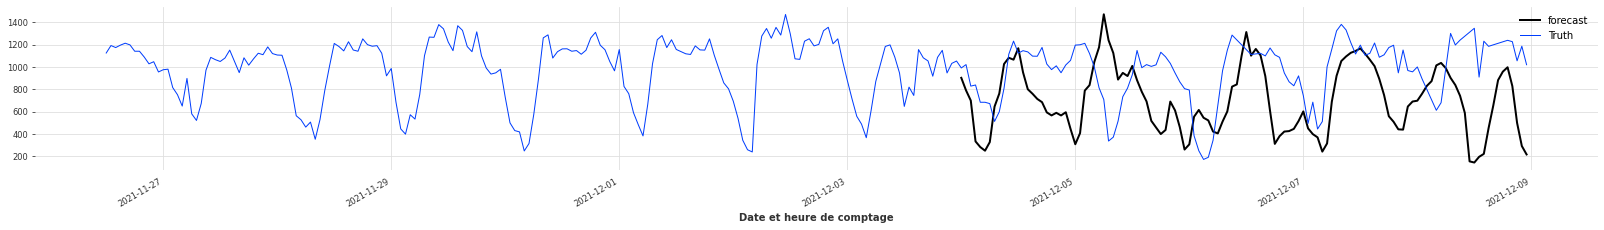

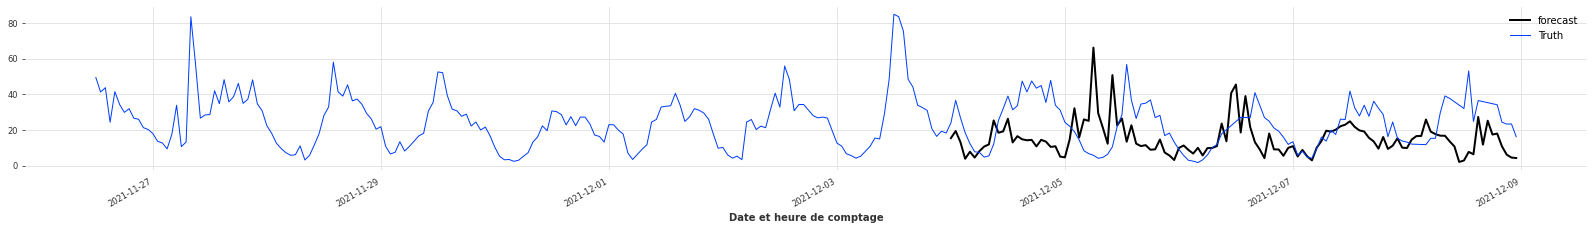

In [68]:
pred = model_2.predict(predict_preiod)
for output in output_cols:
    plt.figure(figsize=(28, 3))
    pred[output].plot(label= "forecast", lw=2, low_quantile=0.1, high_quantile=0.9)
    ts[output][-300:].plot(label="Truth", lw=1)
    plt.show()

## Backtesting

  0%|          | 0/4 [00:00<?, ?it/s]

[2021-12-10 14:42:26,951] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 475 samples.
[2021-12-10 14:42:26,951] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 475 samples.
[2021-12-10 14:42:26,965] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-10 14:42:26,965] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-10 14:43:41,729] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 575 samples.
[2021-12-10 14:43:41,729] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 575 samples.
[2021-12-10 14:45:07,877] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 675 samples.
[2021-12-10 14:45:07,877] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 675 sampl

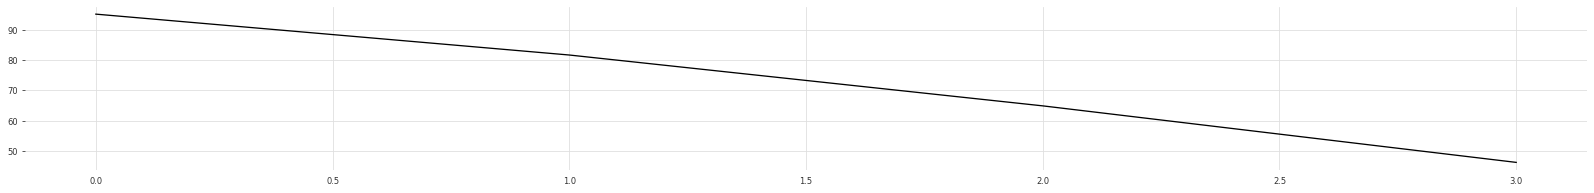

In [62]:
from darts.models import TFTModel
from darts.metrics import mape, mase

model_2 = TFTModel(input_chunk_length=24, output_chunk_length=1, add_relative_index =True, full_attention = False, num_attention_heads=1, lstm_layers = 1, hidden_size=3)
errors = model_2.backtest(train[-1000:][output_cols[0]], verbose=True, stride=100, last_points_only=False, reduction=None, forecast_horizon=predict_preiod, metric=mape)

plt.figure(figsize=(28, 3))
plt.plot(errors)
# pred = model.predict(predict_preiod)
# pred[-500:].plot(lw=2)
# ts[-500:].plot(lw=1)
# plt.show()
# print("mape :", mape(val[output_cols[0]], pred))
# print("mase :", mase(val[output_cols[0]], pred))

In [64]:
errors

[95.32916671647429, 81.76776640379903, 64.89919955515187, 46.14954703316831]